In [1]:
import numpy as np
import pydicom
from mask_functions import mask2rle, rle2mask
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

In [6]:
ROOT_DIR = os.path.abspath("../")
SIIM_DIR = os.path.join(ROOT_DIR, "datasets/pneumothorax")
datadir = os.path.join(SIIM_DIR,'val')
csvfile = os.path.join(datadir,'val-rle.csv')
imagepath = os.path.join(datadir, '1.2.276.0.7230010.3.1.4.8323329.32034.1517875158.122247.dcm')

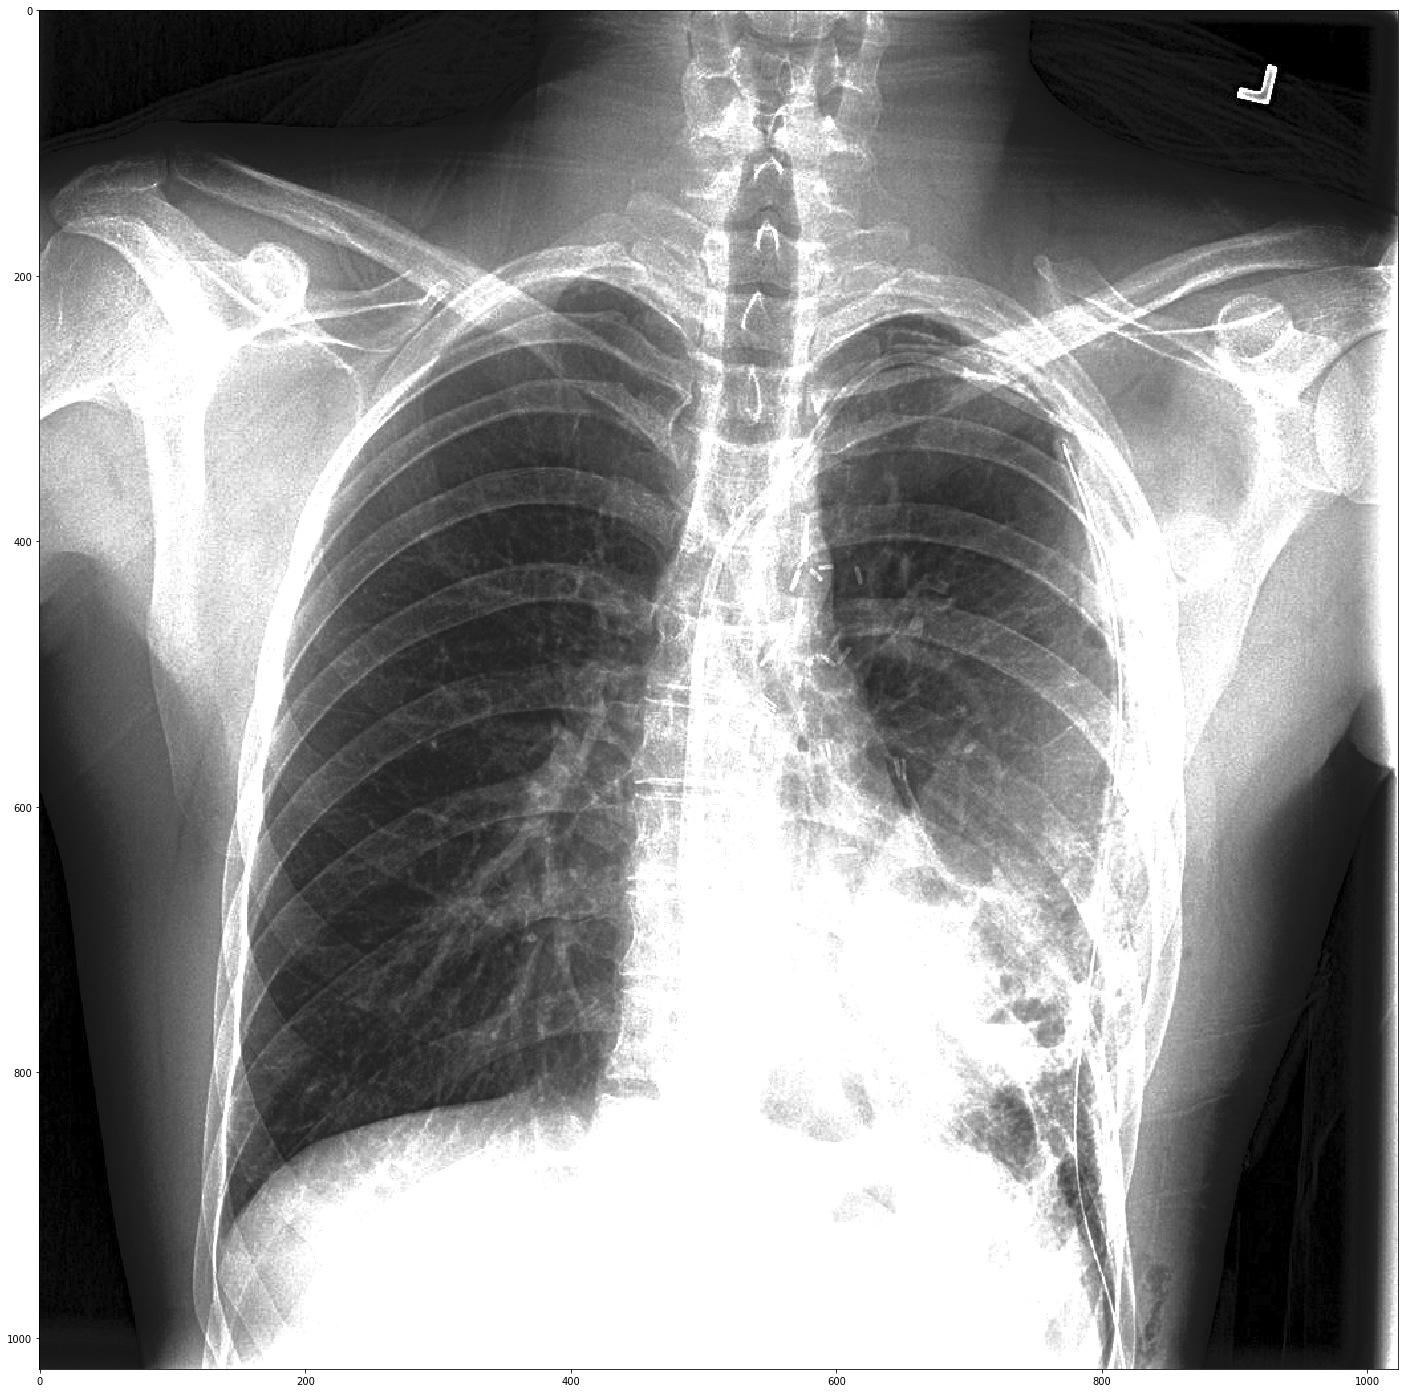

In [7]:



df = pd.read_csv(csvfile,header = None)
#df.columns['ImageId','Encodings']
dcm = pydicom.dcmread(imagepath)
pixel = dcm.pixel_array
samples = df.iloc[:, -1].values
rle_m = rle2mask(samples[161], 1024, 1024)
#annotation = df.loc[df['ImageId'] =='1.2.276.0.7230010.3.1.4.8323329.1314.1517875167.222290']
gamma = 2
kernel1 = np.ones((3,3),np.uint8)
# Elliptical Kernel

kernel2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3))
kernel3 = np.array([[0, 0, 1, 0, 0],
       [0, 1, 1, 1, 0],
       [1, 1, 1, 1, 1],
       [0, 1, 1, 1, 0],
       [0, 0, 1, 0, 0]]).astype(np.uint8)

def enhance_gamma(image, gamma):

    max_pixel = np.max(image)
    height,width = image.shape
    e_image = np.zeros(image.shape)
    for h in range(0,height):
        for w in range(0,width):
            e_image[h,w] = (image[h,w]/max_pixel)**gamma
    e_image = e_image * 255
    e_image = e_image.astype(np.uint8)
    #e_image = cv2.medianBlur(e_image,ksize=3)

    #e_image = cv2.erode(e_image, None, iterations=2)
    #e_image = cv2.dilate(e_image, None, iterations=2)
    return e_image


def display(pixel):

    fig, axes = plt.subplots(1, figsize=(25,25))
    #str = "/home/sa-279/Mask_RCNN/datasets/pneumothorax/val/1.2.276.0.7230010.3.1.4.8323329.10557.1517875224.257683.dcm"

    pixel = pixel
    #display_enhanced_gamma(pixel)
    im = Image.fromarray(pixel)
    #im.save(os.path.join(ROOT_DIR,"siim\\1.2.276.0.7230010.3.1.4.8323329.1314.1517875167.222290.png"))
    axes.imshow(pixel, cmap="gray")
    plt.show()



def smoothimage(image):
     #image = cv2.erode(image, None, iterations=2)
     image = cv2.dilate(image, kernel3, iterations=10)
     return image




enhanced_hist = cv2.equalizeHist(pixel)
remove_noise = cv2.fastNlMeansDenoising(pixel,None,3,7,21)
blur = cv2.GaussianBlur(remove_noise,(3,3),0)
sharpen = cv2.addWeighted(enhanced_hist,1.0,blur,-1.0,0)
enhanced_pixel = cv2.addWeighted(enhanced_hist,1.0, sharpen,0.7,0)
display(enhanced_pixel)
